In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
import random
import math
import scipy.stats as stats
import scipy.io 
import scipy.integrate as integrate
from numba import jit, int32
import numba
import time


In [2]:
#Model parameters

c1 = 0.5
xi = 8.5
q_c = 7
q_e = 0.093
tau_q = 15
T_mean = 16.6
alpha_q = q_c*q_e*np.exp(q_e*T_mean)/tau_q
#gamma = 6.53
gamma = 5.75

chi_A = 0.31
chi_O = 1.38

Q_mean = 0.9

dA = 0.1
dO = 0.5

re = 0.5
rw = 0.5

a = chi_O*c1*gamma
b = c1*xi*alpha_q

Q1 =  chi_A*alpha_q/(2 - 2*Q_mean)
Q2 =  chi_A*alpha_q/(3 - 3*Q_mean)



In [3]:
#Model initialization

LO = 6/5
LA = 8/3

NO = 50


xO = np.linspace(0,LO,NO)
dxO = xO[1] - xO[0]


t_f = 3*9.6
t_N = 960


t = np.linspace(0,t_f,t_N)
dt = t[1] - t[0]


W = 10
#W = 50

c1 = 0.5





r_K = np.exp(-dA*(LA-LO))
r_R = np.exp(3*dA*(LA-LO))

KA = np.zeros((W,t_N,NO))
RA = np.zeros((W,t_N,NO))
KA_sum = np.zeros((W,t_N,NO))
RA_sum = np.zeros((W,t_N,NO))

KO = np.zeros((W,t_N,NO))
RO = np.zeros((W,t_N,NO))

T = np.zeros((W,t_N,NO))



KO[:,0,:] = np.linspace(0.5, 0.25 ,NO)
RO[:,0,0] = (1/rw)*KO[0,0,0]
RO[:,0,NO-1] = re*KO[0,0,NO-1]
RO[:,0,:] = np.linspace(RO[0,0,0] , RO[0,0,NO-1]  ,NO)



T[:,0,:] = np.linspace(0.1, -0.1 ,NO)


V_K = np.zeros((W,t_N))
V_R = np.zeros((W,t_N))





OU_MC = np.zeros((W,t_N))





#OU process parameters 
dp = 1.0
#dp = 0

sigma = 1.2
#sigma3 = 0

ap = -0.25
#ap = 0

eta = 1.5 + (0.5*np.tanh(7.5*(xO - LO/2)))
sp_x = np.exp(-45*(xO - LO/4)**2)
eps = 0.1

OU_MC[:,0] = 0


drift = lambda y,t: -y*dp # define drift term, 
diffusion = lambda y,t: sigma # define diffusion term
noise = np.zeros((W,t_N))
#noise = np.random.normal(loc=0,scale=3.5,size=t_N)*np.sqrt(dt)

In [4]:
dt

0.030031282586027108

In [5]:
dxO

0.024489795918367346

In [6]:
np.shape(noise)

(10, 960)

In [7]:
for w in range(0,W):
    noise[w,:] = np.random.normal(loc=0,scale=1.0,size=t_N)

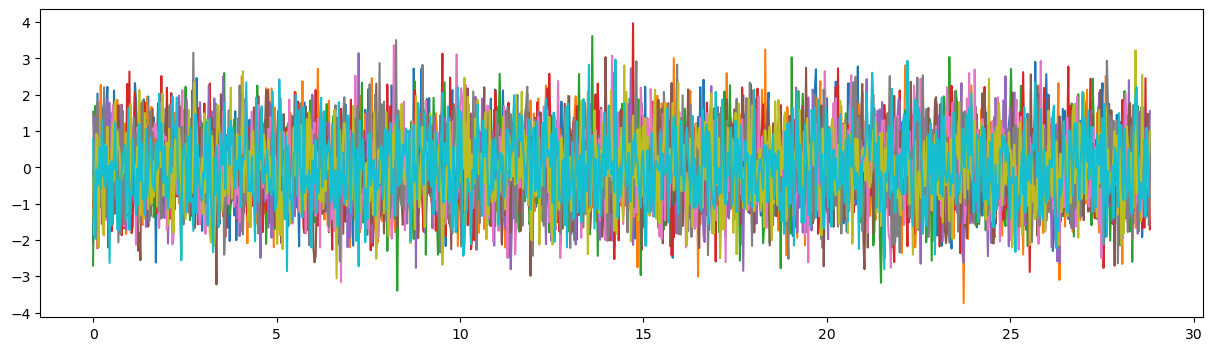

In [8]:
fig = plt.figure(figsize=(15,4))

for k in range(0,W):
    plt.plot(t,noise[k])
#plt.plot(t,noise[1])
#plt.plot(t,noise[2])
#plt.plot(t,noise[3])
#plt.plot(t,noise[4])

In [9]:
for i in range(t_N-1):
    for w in range(0,W):
        OU_MC[w,i+1] = OU_MC[w,i]  + dp*ap*dt + drift(OU_MC[w,i],i*dt)*dt + np.sqrt(dt)*diffusion(OU_MC[w,i],i*dt)*noise[w,i]

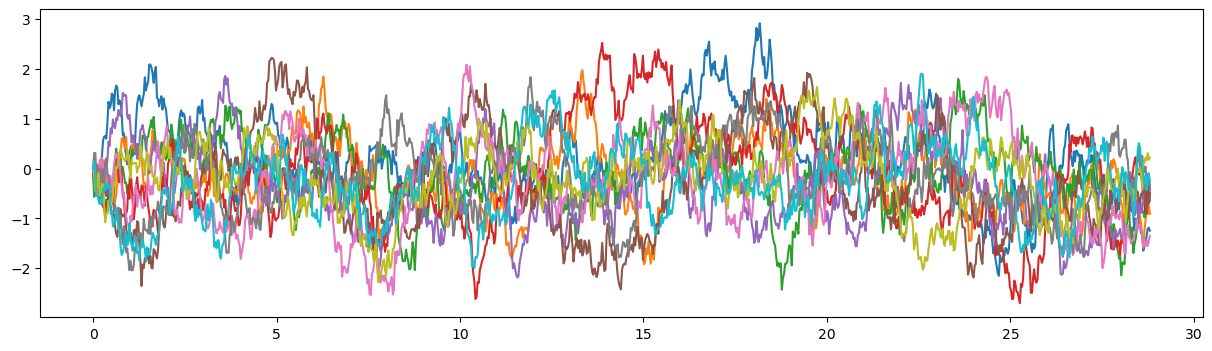

In [10]:
fig = plt.figure(figsize=(15,4))

for k in range(0,W):
    plt.plot(t,OU_MC[k,:])
#plt.plot(t,OU[1,:])
#plt.plot(t,OU[2,:])
#plt.plot(t,OU[3,:])
#plt.plot(t,OU[4,:])
#plt.plot(OU[5,:])
#plt.plot(OU[6,:])
#plt.plot(OU[7,:])
#plt.plot(OU[8,:])

In [11]:
start = time.time()
for i in range(t_N-1):
    for w in range(0,W):
        V_K[w,0] = sum(Q1*(np.exp(-dA*LO))*np.exp(dA*xO[j-1])*(T[w,0,j]+T[w,0,j-1])*dxO/2 for j in range(1,NO)) 
        V_R[w,0] = sum(-3*Q2*(np.exp(3*dA*LO))*np.exp(-3*dA*xO[j-1])*(T[w,0,j]+T[w,0,j-1])*dxO/2 for j in range(1,NO)) 
        for j in range(0,NO):
            KA[w,0,j] = V_K[w,0]*np.exp(-dA*xO[j])/(r_K - np.exp(-dA*LO)) + sum(Q1*np.exp(-dA*xO[j])*np.exp(dA*xO[k-1])*(T[w,0,k]+T[w,0,k-1])*dxO/2  for k in range(1,j+1)) 
            RA[w,0,j] = V_R[w,0]*np.exp(3*dA*xO[j])/(r_R - np.exp(3*dA*LO)) + sum(-3*Q2*np.exp(3*dA*xO[j])*np.exp(-3*dA*xO[k-1])*(T[w,0,k]+T[w,0,k-1])*dxO/2  for k in range(1,j+1))  
        for j in range(1,NO):  
            KO[w,i+1,j] = KO[w,i,j] - (c1)*(dt/dxO)*((KO[w,i,j] - KO[w,i,j-1])) - dt*dO*KO[w,i,j] + dt*(a/2)*(KA[w,i,j] - RA[w,i,j] + sp_x[j]*OU_MC[w,i]) 
            KO[w,i+1,0] = KO[w,i,0] - (c1)*(dt/dxO)*(KO[w,i,0] - rw*RO[w,i,0])  - dt*dO*KO[w,i,0] + dt*(a/2)*(KA[w,i,0] - RA[w,i,0] + sp_x[0]*OU_MC[w,i])                                                                                                                 
        for j in range(0,NO-1):
            RO[w,i+1,j] = RO[w,i,j] + (c1/3)*(dt/dxO)*((RO[w,i,j+1] - RO[w,i,j])) - dt*dO*RO[w,i,j] - dt*(a/3)*(KA[w,i,j] - RA[w,i,j]+ sp_x[j]*OU_MC[w,i]) 
            RO[w,i+1,NO-1] = RO[w,i,NO-1] + (c1/3)*(dt/dxO)*(re*KO[w,i,NO-1] - RO[w,i,NO-1]) - dt*dO*RO[w,i,NO-1] - dt*(a/3)*(KA[w,i,NO-1] - RA[w,i,NO-1]+ sp_x[NO-1]*OU_MC[w,i]) 
        for j in range(0,NO):    
            T[w,i+1,j] = T[w,i,j]  -  dt*b*T[w,i,j] + (c1)*(dt)*(eta[j])*(KO[w,i,j] + RO[w,i,j])
        V_K[w,i+1] = sum(Q1*(np.exp(-dA*LO))*np.exp(dA*xO[j-1])*(T[w,i+1,j]+T[w,i+1,j-1])*dxO/2 for j in range(1,NO))
        V_R[w,i+1] = sum(-3*Q2*(np.exp(3*dA*LO))*np.exp(-3*dA*xO[j-1])*(T[w,i+1,j]+T[w,i+1,j-1])*dxO/2 for j in range(1,NO))
        for j in range(0,NO):
            KA[w,i+1,j] = V_K[w,i+1]*np.exp(-dA*xO[j])/(r_K - np.exp(-dA*LO)) + sum( Q1*np.exp(-dA*xO[j])*np.exp(dA*xO[k-1])*(T[w,i+1,k]+T[w,i+1,k-1])*dxO/2  for k in range(1,j+1))
            RA[w,i+1,j] = V_R[w,i+1]*np.exp(3*dA*xO[j])/(r_R - np.exp(3*dA*LO)) + sum(-3*Q2*np.exp(3*dA*xO[j])*np.exp(-3*dA*xO[k-1])*(T[w,i+1,k]+T[w,i+1,k-1])*dxO/2  for k in range(1,j+1))
end = time.time()
print(end - start)                            

168.48682260513306


In [12]:
scipy.io.savemat('Coupled_Linear_MC_10.mat', {'Kelvin_Atmosphere': KA, 'Rossby_Atmosphere' : RA, 'Kelvin_Ocean' : KO, 'Rossby_Ocean' : RO, 
                                                    'Temperature' : T,'OU_MC': OU_MC , 'noise':noise ,'VK' : V_K, 'VR' : V_R, }) 